In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import abspath, dirname, join
import sys
from glob import glob
import random
import hydra
from hydra.experimental import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf, DictConfig
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
from tqdm import tqdm
import torch

root = abspath(join(dirname("__file__"), '../../'))
sys.path.append(root)
from src.data.generator.detection.build import get_training_datasets

import matplotlib.pyplot as plt

# Initializing Hydra
There are several ways to initialize. See the [API docs](https://hydra.cc/docs/next/experimental/compose_api/#api-documentation) for full details.
All methods support both a function call style that changes the global state, and a context style that cleans up when theg scope exits.

## Global initialization
Calling each of the initilizaiton methods outside of a context changes the global state.

In [3]:
config_path = '../../configs'
config_name='test'

In [4]:
model_name = 'effdet_person_ca_v5'
model_folder = 'person' #'20200914_20_41_11'

In [5]:
# clear hyudra instance for running twice
hydra.core.global_hydra.GlobalHydra.instance().clear()

In [6]:
initialize(config_path=config_path)
model_id = '${MODEL_ID}'
cfg = compose(overrides=[f'+experiment={model_name}', f'MODEL_PATH=models/{model_id}/{model_folder}/', 'DATA.DATA_ID=demo_detection','DATA.TRAIN_IMAGE_DIR=data/${DATA.DATA_ID}/raw/train', 'TEST.TEST_IMAGE_DIR=data/${DATA.DATA_ID}/raw/test',
                         'DATA.CSV_PATH=data/${DATA.DATA_ID}/split/train_folds_demo.csv', 'DATA.PROCESSED_CSV_NAME=_features.csv', 'DATA.EXTRACT_ONE_CLASS=true', 'DATA.FOLD_TARGET_COL=count',
                         '+augmentation=albumentations'], config_name=config_name)
print(cfg)

{'FRAMEWORK': 'pytorch', 'TASK': 'detection', 'MODEL_PATH': 'models/${MODEL_ID}/person/', 'TEST_ID': 'test', 'DATA': {'DATA_ID': 'demo_detection', 'TRAIN_IMAGE_DIR': 'data/${DATA.DATA_ID}/raw/train', 'CVAT_TASK_TYPE': 'object_detection', 'EXTRACT_ONE_CLASS': True, 'PROCESSED_CSV_NAME': '_features.csv', 'CSV_PATH': 'data/${DATA.DATA_ID}/split/train_folds_demo.csv', 'RANDOM_KFOLD': False, 'TEST_SIZE': 0.2, 'N_FOLD': 1, 'FORMAT': 'pascal_voc', 'IMAGE_ID_COL_NAME': 'ImageID', 'FOLD_TARGET_COL': 'count', 'REMOVE_LARGE_BBOXES': False, 'LARGE_BBOX_AREA_THRESHOLD': 200000}, 'DATASET': {'CLASS_NAME': 'src.data.generator.detection.dataset.DatasetRetriever', 'CUTMIX': False}, 'TEST': {'BATCH_SIZE': 1, 'TEST_IMAGE_DIR': 'data/${DATA.DATA_ID}/raw/test', 'TEST_CSV_PATH': 'data/${DATA.DATA_ID}/split/test_person_v3.csv', 'VISUALIZE_RESULTS': True, 'VAL_PRED_IMG_DIR': 'pred_images/validation/', 'TEST_PRED_IMG_DIR': 'pred_images/test/', 'SAVE_ALL_IMAGES': False, 'DETECTION_THRESHOLD': 0.2, 'FIND_BEST_TH

# Check Augmentations

## Move to Root Directory(./BaseModel)

In [7]:
%cd ../../

/data1/r_suzuki/pipeline/BaseModel


## Get Datasets

In [8]:
fold = 0
datasets = get_training_datasets(cfg, fold)
train_dataset = datasets['train']
valid_dataset = datasets['valid']

Train df length: 13
Val df length: 24
Framework: albumentations


## Plot a Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


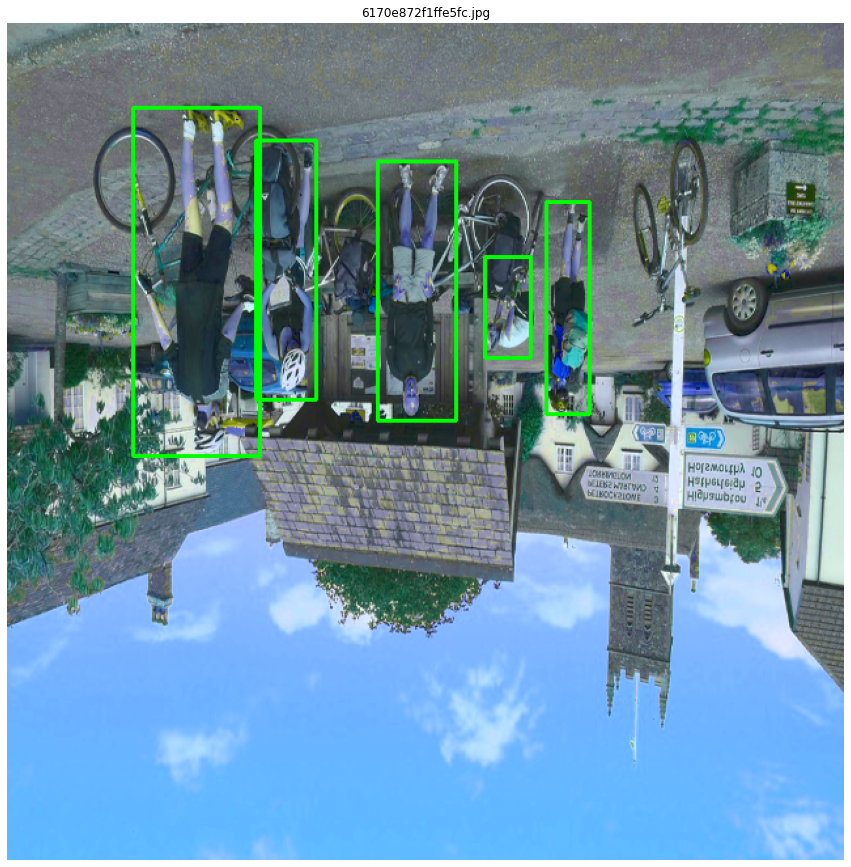

In [9]:
idx = 2
image, target, image_id = train_dataset.__getitem__(idx)

fig, ax = plt.subplots(1, 1, figsize=(15, 20))
img = image.to('cpu').detach().numpy().copy()
img = img.transpose(1,2,0)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for i in target['boxes']:
    xmin = int(i[1])
    ymin = int(i[0])
    xmax = int(i[3])
    ymax = int(i[2])
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax),(0,255,0), 2)
    
ax.set_axis_off()
ax.set_title(f'{image_id}.jpg')
ax.imshow(img)

# Make Augmentations using Albumentations

[Albumentations Github Page](https://github.com/albumentations-team/albumentations)

## How to save and load parameters of an augmentation pipeline


[Official Document](https://albumentations.ai/docs/examples/serialization/)

### Define an augmentation pipeline that we want to serialize

In [10]:
def get_train_transforms():
	return A.Compose(
            [
#                 A.RandomSizedCrop(min_max_height=(800, 1024), height=1024, width=1024, p=0.5),
                A.OneOf([
                    A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),
                    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9),
                ],p=0.9),
                A.ToGray(p=0.01),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.Transpose(p=0.5),
#                 A.JpegCompression(quality_lower=85, quality_upper=95, p=0.2),
                A.OneOf([
                    A.Blur(blur_limit=3, p=1.0),
                    A.MedianBlur(blur_limit=3, p=1.0)
                    ],p=0.1),
                A.Resize(height=1024, width=1024, p=1),
                A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
                ToTensorV2(p=1.0),
            ], p=1.0,
            bbox_params=A.BboxParams(
                format='pascal_voc',
                min_area=0,
                min_visibility=0,
                label_fields=['labels']
                )
            )

In [11]:
train_augs = get_train_transforms()

In [12]:
train_augs

Compose([
  OneOf([
    HueSaturationValue(always_apply=False, p=0.9, hue_shift_limit=(-0.2, 0.2), sat_shift_limit=(-0.2, 0.2), val_shift_limit=(-0.2, 0.2)),
    RandomBrightnessContrast(always_apply=False, p=0.9, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
  ], p=0.9),
  ToGray(always_apply=False, p=0.01),
  HorizontalFlip(always_apply=False, p=0.5),
  VerticalFlip(always_apply=False, p=0.5),
  RandomRotate90(always_apply=False, p=0.5),
  Transpose(always_apply=False, p=0.5),
  OneOf([
    Blur(always_apply=False, p=1.0, blur_limit=(3, 3)),
    MedianBlur(always_apply=False, p=1.0, blur_limit=(3, 3)),
  ], p=0.1),
  Resize(always_apply=False, p=1, height=1024, width=1024, interpolation=1),
  Cutout(always_apply=False, p=0.5, num_holes=8, max_h_size=64, max_w_size=64),
  ToTensorV2(always_apply=True, p=1.0),
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['labels'], 'min_area': 0, 'min_visibility': 0}, keypoint_params=None, additio

In [13]:
!pwd

/data1/r_suzuki/pipeline/BaseModel


### Save Augmentations as yaml file

In [14]:
A.core.serialization.save(train_augs, './configs/augmentation/train_aug_tutorial.yaml', data_format='yaml')

### Load Augmentations from yaml file

In [15]:
train_augs_loaded = A.load('./configs/augmentation/train_aug_tutorial.yaml', data_format='yaml')

In [16]:
train_augs_loaded

Compose([
  OneOf([
    HueSaturationValue(always_apply=False, p=0.9, hue_shift_limit=(-0.2, 0.2), sat_shift_limit=(-0.2, 0.2), val_shift_limit=(-0.2, 0.2)),
    RandomBrightnessContrast(always_apply=False, p=0.9, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
  ], p=0.9),
  ToGray(always_apply=False, p=0.01),
  HorizontalFlip(always_apply=False, p=0.5),
  VerticalFlip(always_apply=False, p=0.5),
  RandomRotate90(always_apply=False, p=0.5),
  Transpose(always_apply=False, p=0.5),
  OneOf([
    Blur(always_apply=False, p=1.0, blur_limit=(3, 3)),
    MedianBlur(always_apply=False, p=1.0, blur_limit=(3, 3)),
  ], p=0.1),
  Resize(always_apply=False, p=1, height=1024, width=1024, interpolation=1),
  Cutout(always_apply=False, p=0.5, num_holes=8, max_h_size=64, max_w_size=64),
  ToTensorV2(always_apply=True, p=1.0),
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['labels'], 'min_area': 0, 'min_visibility': 0}, keypoint_params=None, additio

### Delete example yaml file

In [17]:
!ls ./configs/augmentation/train_aug_tutorial.yaml

./configs/augmentation/train_aug_tutorial.yaml


In [18]:
!rm ./configs/augmentation/train_aug_tutorial.yaml

In [19]:
!ls ./configs/augmentation/train_aug_tutorial.yaml

ls: cannot access './configs/augmentation/train_aug_tutorial.yaml': No such file or directory
